In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import math

In [3]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_sample = pd.read_csv("sample_submission.csv")

In [4]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
df_sample.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [9]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             625134 non-null  object
 1   trip_duration  625134 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


In [10]:
def get_distance(source_lat, source_long, dest_lat, dest_long):
    # Returns the distance in Miles between the source and the destination.
    
    distance = geodesic((source_lat, source_long), 
                        (dest_lat, dest_long)).miles
    return distance

In [11]:
df_train['distance'] = df_train.apply(lambda x: get_distance(x.pickup_latitude, x.pickup_longitude,
                                                       x.dropoff_latitude, x.dropoff_longitude), axis=1)

df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.933406
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.123849
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.964154
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.921886
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.737591


In [12]:
df_test['distance'] = df_test.apply(lambda x: get_distance(x.pickup_latitude, x.pickup_longitude,
                                                     x.dropoff_latitude, x.dropoff_longitude), axis=1)

df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,1.704336
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,1.712358
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,0.812202
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,3.272749
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,0.597601


C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_duration', ylabel='Density'>

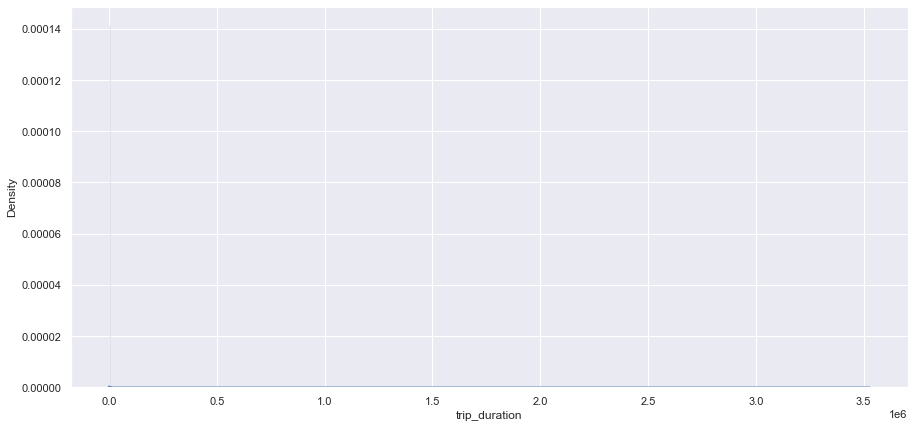

In [13]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.distplot(df_train['trip_duration'].values, axlabel = 'trip_duration', bins = 500)

C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Trip Duration (in Hours)', ylabel='Density'>

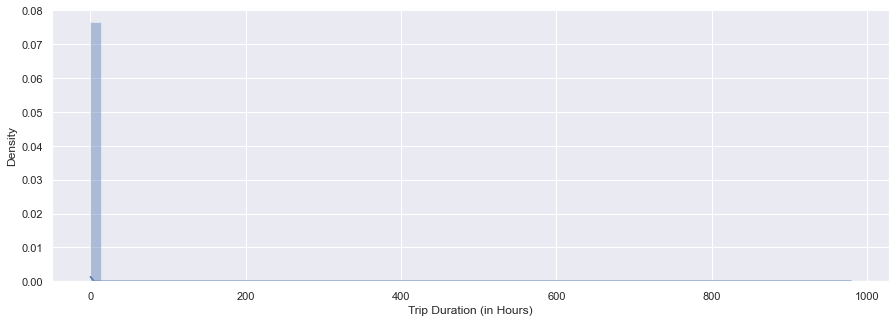

In [14]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.distplot(df_train['trip_duration'].values/3600, axlabel = 'Trip Duration (in Hours)', bins = 75)

C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Trip Distance', ylabel='Density'>

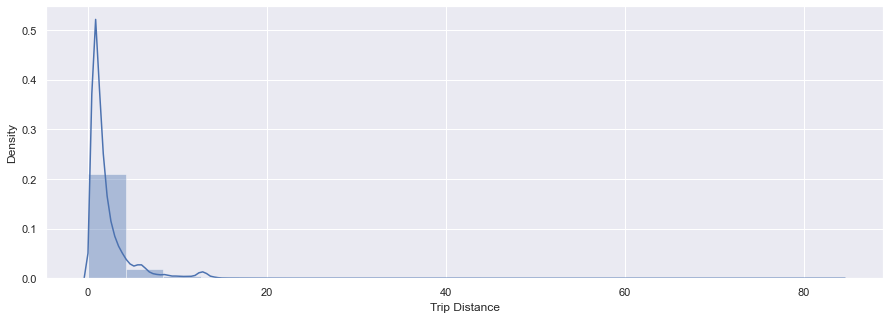

In [15]:
df_filtered = df_train[df_train['distance'] <= 100].copy()
sns.distplot(df_filtered['distance'].values, axlabel = 'Trip Distance', bins = 20)

C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Trip Distance', ylabel='Density'>

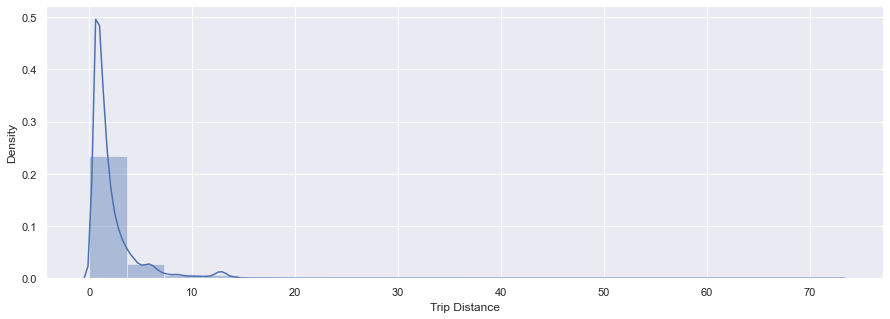

In [16]:
df_filtered = df_test[df_test['distance'] <= 100].copy()
sns.distplot(df_filtered['distance'].values, axlabel = 'Trip Distance', bins = 20)

C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Trip Distance in Miles (Filtered)', ylabel='Density'>

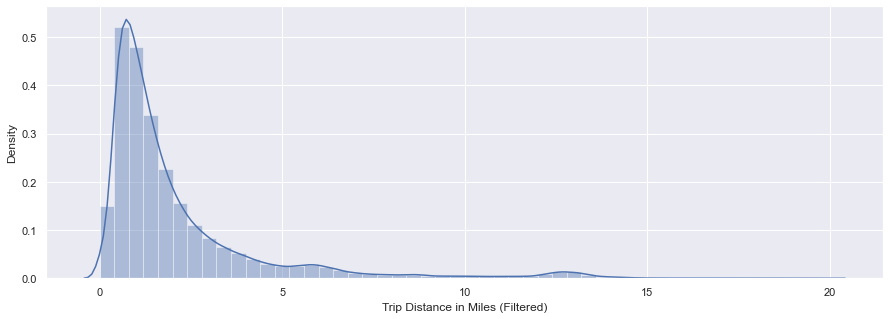

In [17]:
df_filtered = df_train[df_train['distance'] <= 20].copy()
sns.distplot(df_filtered['distance'].values, axlabel = 'Trip Distance in Miles (Filtered)', bins = 50)

C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Trip Distance in Miles (Filtered)', ylabel='Density'>

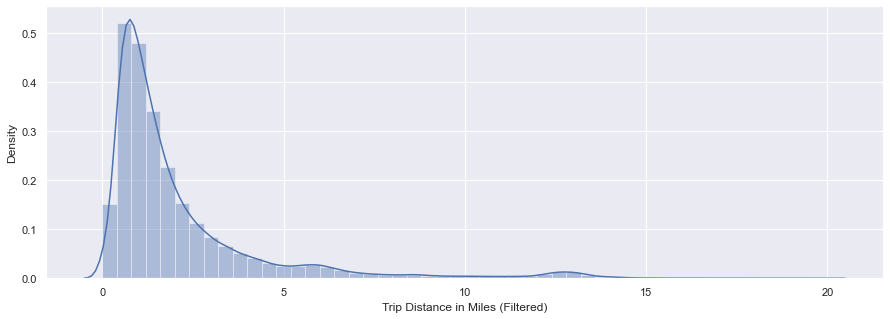

In [18]:
df_filtered = df_test[df_test['distance'] <= 20].copy()
sns.distplot(df_filtered['distance'].values, axlabel = 'Trip Distance in Miles (Filtered)', bins = 50)

<AxesSubplot:xlabel='distance', ylabel='trip_duration'>

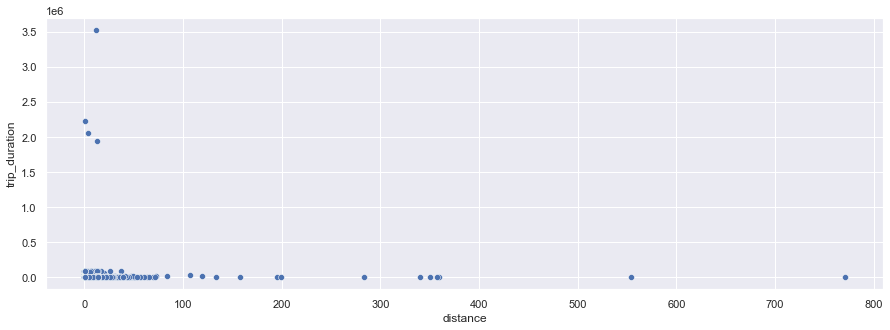

In [19]:
sns.scatterplot(data=df_train, x="distance", y="trip_duration")

In [20]:
clf = IsolationForest(random_state = 42, contamination = 0.01)
df_train['Anomaly'] = clf.fit_predict(df_train[['distance', 'trip_duration']])
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,Anomaly
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.933406,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.123849,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.964154,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.921886,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.737591,1


In [21]:
df_train.Anomaly.value_counts()

 1    1444061
-1      14583
Name: Anomaly, dtype: int64

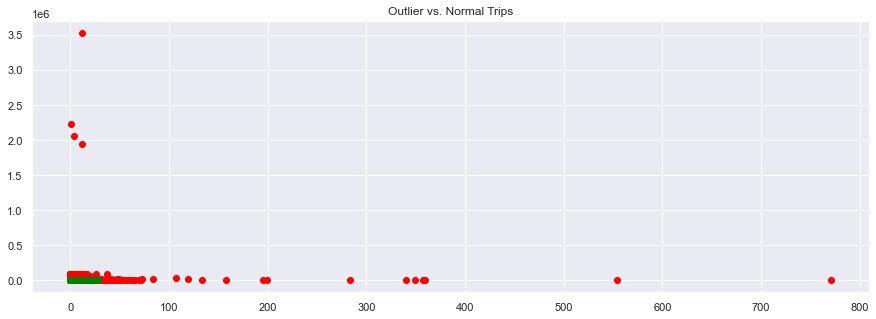

In [22]:
plt.title("Outlier vs. Normal Trips")
plt.rcParams['figure.figsize'] = [15, 7]

plt.scatter(df_train.loc[df_train.Anomaly == -1, ['distance']], 
                 df_train.loc[df_train.Anomaly == -1, ['trip_duration']], c='red')
plt.scatter(df_train.loc[df_train.Anomaly == 1, ['distance']], 
                 df_train.loc[df_train.Anomaly == 1, ['trip_duration']], c='green')
plt.show()

<AxesSubplot:xlabel='distance', ylabel='trip_duration'>

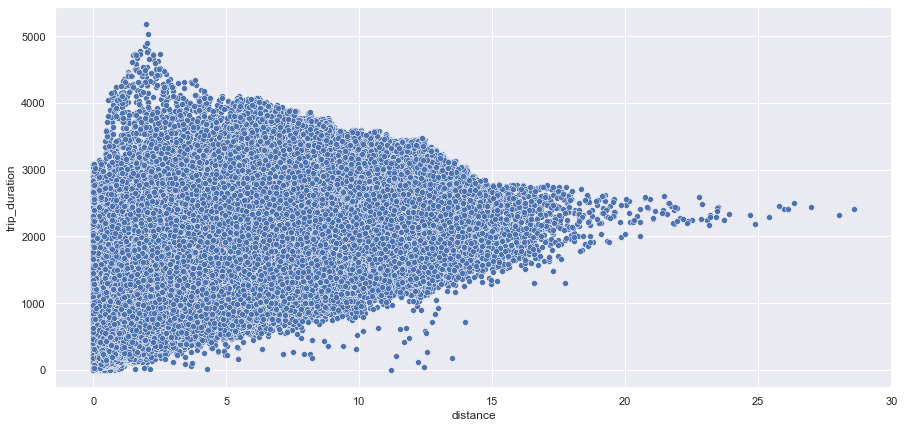

In [23]:
df_train = df_train.loc[df_train['Anomaly'] == 1].copy()
sns.scatterplot(data=df_train, x="distance", y="trip_duration")

In [24]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1444061 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1444061 non-null  object        
 1   vendor_id           1444061 non-null  int64         
 2   pickup_datetime     1444061 non-null  datetime64[ns]
 3   dropoff_datetime    1444061 non-null  datetime64[ns]
 4   passenger_count     1444061 non-null  int64         
 5   pickup_longitude    1444061 non-null  float64       
 6   pickup_latitude     1444061 non-null  float64       
 7   dropoff_longitude   1444061 non-null  float64       
 8   dropoff_latitude    1444061 non-null  float64       
 9   store_and_fwd_flag  1444061 non-null  object        
 10  trip_duration       1444061 non-null  int64         
 11  distance            1444061 non-null  float64       
 12  Anomaly             1444061 non-null  int32         
dtypes: datetime6

In [25]:
df_test['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_test['dropoff_datetime'] = pd.to_datetime(df_train['dropoff_datetime'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     618965 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
 9   distance            625134 non-null  float64       
 10  dropoff_datetime    618965 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int64(2), object(2)
memory usage: 52.5+ MB


In [26]:
df_train['date'] = df_train['pickup_datetime'].dt.date
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,Anomaly,date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.933406,1,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.123849,1,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.964154,1,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.921886,1,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.737591,1,2016-03-26


In [27]:
df_test['date'] = df_test['pickup_datetime'].dt.date
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,dropoff_datetime,date
0,id3004672,1,2016-03-14 17:24:55,1,-73.988129,40.732029,-73.990173,40.756680,N,1.704336,2016-03-14 17:32:30,2016-03-14
1,id3505355,1,2016-06-12 00:43:35,1,-73.964203,40.679993,-73.959808,40.655403,N,1.712358,2016-06-12 00:54:38,2016-06-12
2,id1217141,1,2016-01-19 11:35:24,1,-73.997437,40.737583,-73.986160,40.729523,N,0.812202,2016-01-19 12:10:48,2016-01-19
3,id2150126,2,2016-04-06 19:32:31,1,-73.956070,40.771900,-73.986427,40.730469,N,3.272749,2016-04-06 19:39:40,2016-04-06
4,id1598245,1,2016-03-26 13:30:55,1,-73.970215,40.761475,-73.961510,40.755890,N,0.597601,2016-03-26 13:38:10,2016-03-26


<AxesSubplot:xlabel='date', ylabel='distance'>

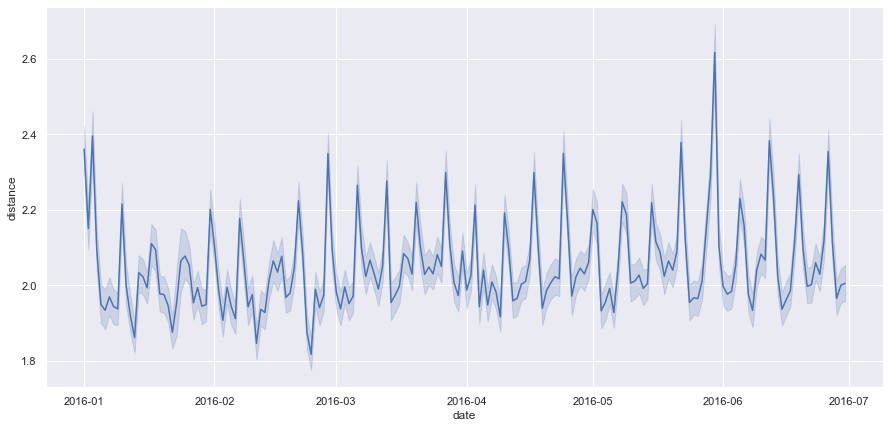

In [28]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.lineplot(x="date", y="distance", data=df_train)

<AxesSubplot:xlabel='date', ylabel='trip_duration'>

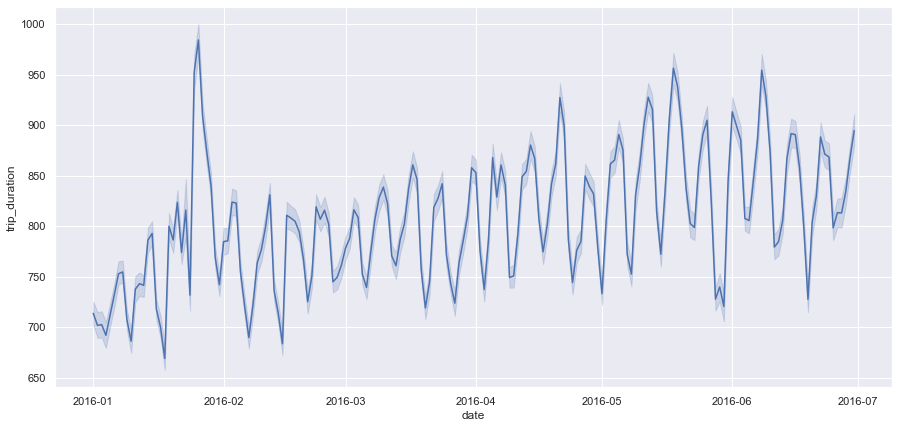

In [29]:
sns.lineplot(x="date", y="trip_duration", data=df_train)

In [30]:
data = df_train.groupby(['date'])['distance'].agg('sum')
data = pd.DataFrame({'date':data.index, 'distance':data.values})
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,distance
0,2016-01-01,16838.602738
1,2016-01-02,13922.008420
2,2016-01-03,15104.819660
3,2016-01-04,13948.077274
4,2016-01-05,13894.070737


<AxesSubplot:xlabel='date', ylabel='distance'>

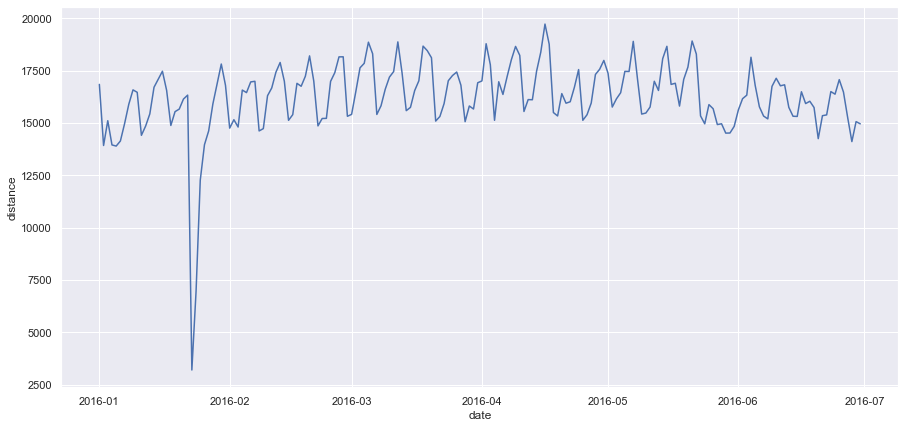

In [31]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.lineplot(x="date", y="distance", data=data)

In [32]:
data.rename(columns = {'distance': 'y', 'date': 'ds'}, inplace = True)
m = Prophet(seasonality_mode='additive').fit(data)
future = m.make_future_dataframe(periods = 30)
forecast = m.predict(future)
fig = m.plot(forecast)

NameError: name 'Prophet' is not defined

In [34]:
data = df_train.groupby(['date'])['trip_duration'].agg('sum')
data = pd.DataFrame({'date':data.index, 'trip_duration':data.values})
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,trip_duration
0,2016-01-01,5090129
1,2016-01-02,4543581
2,2016-01-03,4429405
3,2016-01-04,4604117
4,2016-01-05,5075864


<AxesSubplot:xlabel='date', ylabel='trip_duration'>

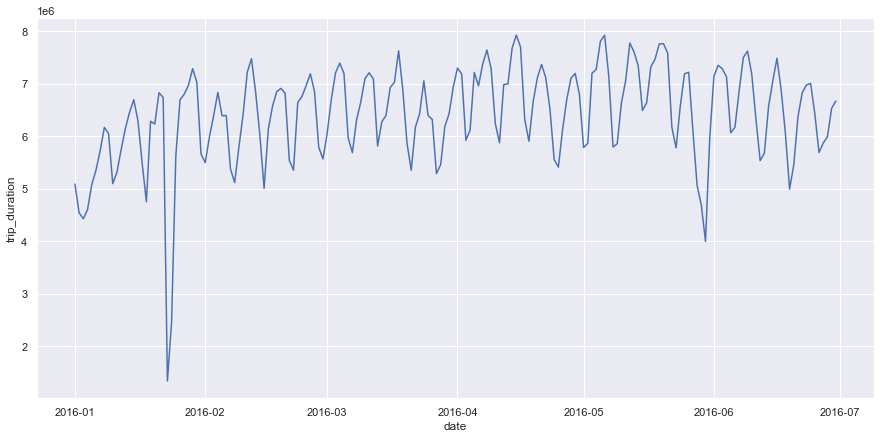

In [35]:
sns.set(rc={'figure.figsize':(15, 7)})
sns.lineplot(x="date", y="trip_duration", data=data)

In [36]:
data.rename(columns = {'trip_duration': 'y', 'date': 'ds'}, inplace = True)
m = Prophet(seasonality_mode='additive').fit(data)
future = m.make_future_dataframe(periods = 30)
forecast = m.predict(future)
fig = m.plot(forecast)


NameError: name 'Prophet' is not defined

In [37]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,Anomaly,date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0.933406,1,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.123849,1,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,3.964154,1,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,0.921886,1,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,0.737591,1,2016-03-26


In [38]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,distance,dropoff_datetime,date
0,id3004672,1,2016-03-14 17:24:55,1,-73.988129,40.732029,-73.990173,40.756680,N,1.704336,2016-03-14 17:32:30,2016-03-14
1,id3505355,1,2016-06-12 00:43:35,1,-73.964203,40.679993,-73.959808,40.655403,N,1.712358,2016-06-12 00:54:38,2016-06-12
2,id1217141,1,2016-01-19 11:35:24,1,-73.997437,40.737583,-73.986160,40.729523,N,0.812202,2016-01-19 12:10:48,2016-01-19
3,id2150126,2,2016-04-06 19:32:31,1,-73.956070,40.771900,-73.986427,40.730469,N,3.272749,2016-04-06 19:39:40,2016-04-06
4,id1598245,1,2016-03-26 13:30:55,1,-73.970215,40.761475,-73.961510,40.755890,N,0.597601,2016-03-26 13:38:10,2016-03-26


In [39]:
df_sample["Conditions"] = df_sample["Conditions"].fillna('Unknown')

weather_dict = {'Overcast' : 0, 
                'Haze' : 0,
                'Partly Cloudy' : 0, 
                'Mostly Cloudy' : 0, 
                'Scattered Clouds' : 0, 
                'Light Freezing Fog' : 0,
                
                'Unknown' : 1,
                'Clear' : 2, 
                
                'Heavy Rain' : 3, 
                'Rain' : 3, 
                'Light Freezing Rain' : 3,
                'Light Rain' : 3, 
                
                'Heavy Snow' : 4,
                'Light Snow' : 4,
                'Snow' : 4}
df_sample["Conditions"] = df_sample["Conditions"].apply(lambda x: weather_dict[x])

KeyError: 'Conditions'

df_sample["trip_duration"] = df_sample["trip_duration"].fillna('Unknown')

distace_dict = {'Id' : 0, 
                'Vendor Id' : 0,
                'Pickup Date Time' : 0, 
                'Passanger Count' : 0, 
                'Pickup Long Attitude' : 0, 
                'Pickup Latitude' : 0,
                
                'Dropoff Long Attitude' : 1,
                'Dropoff Lattitude' : 2, 
                
                'Store and  Forward Flag' : 3, 
                'Trip Duration' : 3, 
                'Distance' : 3
df_sample["trip_duration"] = df_sample["trip_duratio0n"].apply(lambda x: distace_dict[x])


In [ ]:
bst = lgb.df_train(params,
                dtrain,
                num_boost_round = nrounds,
                valid_sets = [dtrain, dval],
                valid_names = ['train', 'valid'],
                categorical_feature = [20, 24]
                )

In [ ]:
df_train = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

watchlist = [(dval, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                evals = watchlist,
                verbose_eval = True
                )